#### Importing Packages and Modules

In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from dotenv import load_dotenv

from schemas import AttractionPlannerState, HotelPlannerState, FoodPlacesPlanner, AgentState
from attractions import Attractions
from hotels import Hotels
from restaurants import Restaurants
from planner import Planner

load_dotenv()

True

#### Attractions and Activities Workflow

In [2]:
workflow = StateGraph(AttractionPlannerState)

workflow.add_node("LLM with Tools", Attractions().llm_attraction_call)
 
tool_node = ToolNode(Attractions().required_tools)

workflow.add_node("Available Tools", tool_node)

workflow.add_edge(START, "LLM with Tools")

workflow.add_edge("Available Tools", "LLM with Tools")

workflow.add_conditional_edges("LLM with Tools",
                                Planner().router_function,
                                {"Run Tools" : "Available Tools",
                                 END : END})

attractions_app = workflow.compile()

#### Hotels Workflow

In [3]:
workflow2 = StateGraph(HotelPlannerState)

workflow2.add_node("LLM with Tools", Hotels().llm_hotel_call)
 
tool_node2 = ToolNode(Hotels().required_tools)

workflow2.add_node("Available Tools", tool_node2)

workflow2.add_edge(START, "LLM with Tools")

workflow2.add_edge("Available Tools", "LLM with Tools")

workflow2.add_conditional_edges("LLM with Tools",
                                Planner().router_function,
                                {"Run Tools" : "Available Tools",
                                 END : END})

hotels_app = workflow2.compile()

#### Restaurants and Food Places Workflow

In [4]:
workflow3 = StateGraph(FoodPlacesPlanner)

workflow3.add_node("LLM with Tools", Restaurants().llm_restaurants_call)
 
tool_node3 = ToolNode(Restaurants().required_tools)

workflow3.add_node("Available Tools", tool_node3)

workflow3.add_edge(START, "LLM with Tools")

workflow3.add_edge("Available Tools", "LLM with Tools")

workflow3.add_conditional_edges("LLM with Tools",
                                Planner().router_function,
                                {"Run Tools" : "Available Tools",
                                 END : END})

restaurants_app = workflow3.compile()

#### Parent Graph Functions Creation

In [5]:
def run_attractions_subgraph(state: AgentState) -> AgentState:
    result = attractions_app.invoke(state["attractions"])
    return {"attractions": result}

def run_hotels_subgraph(state: AgentState) -> AgentState:
    result = hotels_app.invoke(state["hotels"])
    return {"hotels": result}

def run_foodplaces_subgraph(state: AgentState) -> AgentState:
    result = restaurants_app.invoke(state["restaurants"])
    return {"restaurants": result}

#### Trip Planner Workflow

In [6]:
from langgraph.graph import StateGraph, START, END

parent_graph = StateGraph(AgentState)

parent_graph.add_node("Attractions Subgraph", run_attractions_subgraph)
parent_graph.add_node("Hotels Subgraph", run_hotels_subgraph)
parent_graph.add_node("Restaurants Subgraph", run_foodplaces_subgraph)
parent_graph.add_node("Consolidator", Planner().trip_planner)

tool_node4 = ToolNode(Planner().required_tools)
parent_graph.add_node("Available Tools", tool_node4)

parent_graph.add_edge(START, "Attractions Subgraph")
parent_graph.add_edge(START, "Hotels Subgraph")
parent_graph.add_edge(START, "Restaurants Subgraph")

parent_graph.add_edge("Attractions Subgraph", "Consolidator")
parent_graph.add_edge("Hotels Subgraph", "Consolidator")
parent_graph.add_edge("Restaurants Subgraph", "Consolidator")


parent_graph.add_conditional_edges("Consolidator",
                                Planner().router_function,
                                {"Run Tools" : "Available Tools",
                                 END : END})

parent_graph.set_finish_point("Consolidator")

trip_planner_app = parent_graph.compile()

#### Workflows Visualizations

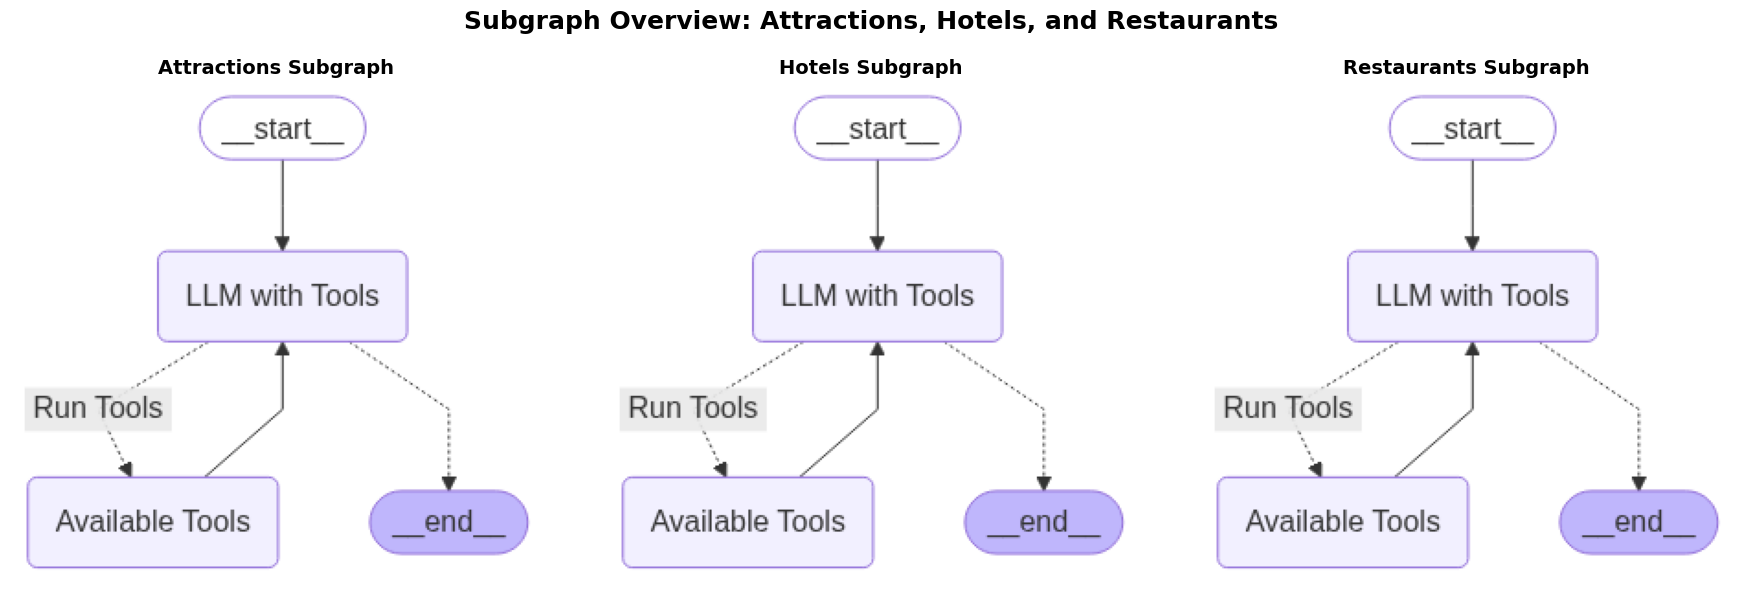

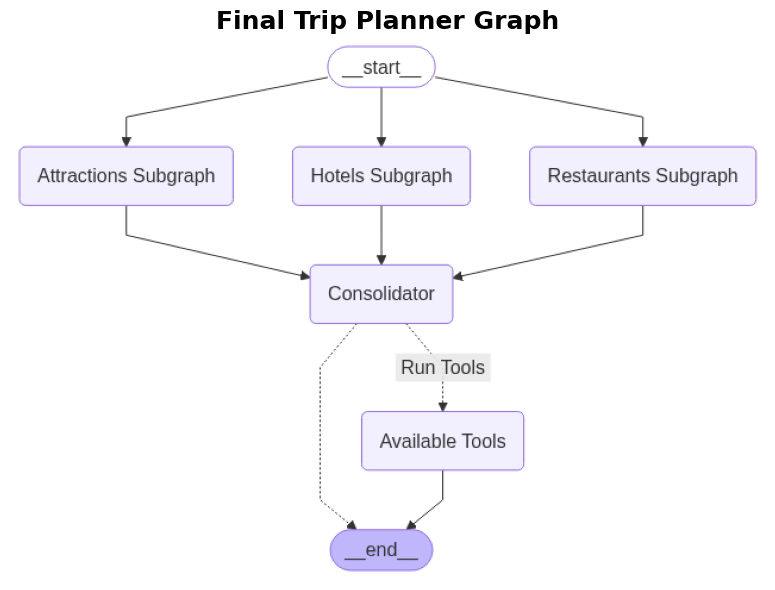

In [7]:
from PIL import Image as PILImage
import io
import matplotlib.pyplot as plt

# Function to convert LangGraph graph to image
def graph_to_image(graph):
    png_bytes = graph.get_graph().draw_mermaid_png()
    return PILImage.open(io.BytesIO(png_bytes))

# Load all graph images
attraction_img = graph_to_image(attractions_app)
hotel_img = graph_to_image(hotels_app)
restaurant_img = graph_to_image(restaurants_app)
final_img = graph_to_image(trip_planner_app)

# === Subgraphs Row ===
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Subgraph Overview: Attractions, Hotels, and Restaurants", fontsize=18, fontweight='bold')

axs[0].imshow(attraction_img)
axs[0].set_title("Attractions Subgraph", fontsize=14, fontweight='bold')
axs[1].imshow(hotel_img)
axs[1].set_title("Hotels Subgraph", fontsize=14, fontweight='bold')
axs[2].imshow(restaurant_img)
axs[2].set_title("Restaurants Subgraph", fontsize=14, fontweight='bold')

# Remove axes
for ax in axs:
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# === Final Graph ===
plt.figure(figsize=(12, 6))
plt.imshow(final_img)
plt.axis('off')
plt.title("Final Trip Planner Graph", fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

#### AI Agent Execution

###### (Customize your query based on your travel needs—such as hotel preferences, restaurant types, preferred currency, or whether you're traveling solo, as a couple, or with family—to get the most relevant suggestions.)

In [ ]:
result = trip_planner_app.invoke({
    "attractions": {
        "messages": ["I am planning to visit Jaipur for 3 days"],
        "travel_type": "Solo",
        "currency" : "USD",
    },
    "hotels": {
        "messages": ["Comfortable and Beautiful Hotels in Jaipur"],
        "travel_type": "Solo",
        "budget": "4000 to 5000 INR Per Day",
        "currency" : "USD",
    },
    "restaurants": {
        "messages": ["I would love to explore restaurants that reflect the Jaipur's cultural heritage and offer authentic local cuisine."],
        "travel_type": "Solo",
        "budget": "No specific budget, the food must be worth the money",
        "currency" : "USD",
    },
    "currency" : "USD",
    "messages": ["I am planning to visit Jaipur for 3 days"],
    "travel_type": "Solo"
})

#### Results Saving in Directory

In [13]:
import os
from datetime import datetime

destination = "Jaipur"

today = datetime.today().strftime('%d %B %Y')

def get_signature():
    return f"""\
# **֎ AI Travel Plan**

---

**📘 Trip Plan generated by:** *Anshul Kalia*  
**🧠 Role:** Machine Learning Engineer | Travel Planner with LangGraph ✈️  
**📅 Generated on:** {today}

---

"""

# Paths
main_folder = destination
detailed_folder = os.path.join(main_folder, "Detailed")

# Ensure folders exist
os.makedirs(main_folder, exist_ok=True)
os.makedirs(detailed_folder, exist_ok=True)

# Map each filename to its content and folder path
file_data_map = {
    os.path.join(main_folder, "Final_Trip_Plan.md"): result.get("final_result", "")[0],
    os.path.join(detailed_folder, "Attractions.md"): result.get("attractions", {}).get("attraction_result", ""),
    os.path.join(detailed_folder, "Hotels.md"): result.get("hotels", {}).get("hotel_result", ""),
    os.path.join(detailed_folder, "Restaurants.md"): result.get("restaurants", {}).get("restaurant_result", ""),
}

# Save each file
for file_path, content in file_data_map.items():
    if content:
        # Add signature only to Final_Trip_Plan.md
        if file_path.endswith("Final_Trip_Plan.md"):
            final_content = get_signature() + "\n\n".join(content) if isinstance(content, list) else get_signature() + content
        else:
            final_content = "\n\n".join(content) if isinstance(content, list) else content

        with open(file_path, "w", encoding="utf-8") as f:
            f.write(final_content)
        print(f"✅ Saved to {file_path}")
    else:
        print(f"⚠️ Skipped {file_path} (no content found)")


✅ Saved to Jaipur/Final_Trip_Plan.md
✅ Saved to Jaipur/Detailed/Attractions.md
✅ Saved to Jaipur/Detailed/Hotels.md
✅ Saved to Jaipur/Detailed/Restaurants.md
